In [158]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import torch.utils.data as Data
import datetime as dt, itertools, pandas as pd, matplotlib.pyplot as plt, numpy as np
import glob
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0，1"
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


(262800, 10)


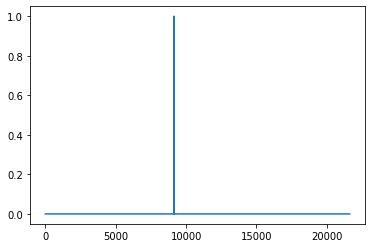

In [417]:
total=pd.read_csv('total_series.csv')
total=total.values
print(total.shape)
total_list=['K117+378','K127+995','K135+913','K145+688','K154+192','K164+845','K174+468','K186+682','K196+146','K203+320']
T=10
step=10
BATCH_SIZE=256

a=[5,6,7,8]
b=6

X0= total[127600:149200+T+step,a]
#targt series
Y0= total[127600:149200+T+step,b]

y_label=np.zeros((len(Y0)))
y_label[Y0>15]=1




In [418]:
index=[]
for i in range(len(y_label)-1):
#     if y_label[i]==0 and y_label[i+1]==1:
#         index.append(i+1)
    if y_label[i]==1:
        index.append(i)
print(len(index))
Turns=len(index)
print(Turns)
RS=np.zeros((Turns,T+step,len(a)))
TS=np.zeros((Turns,T+step))
for i  in range(Turns):
    RS[i]=X0[index[i]-T:index[i]+step,:]
    TS[i]=Y0[index[i]-T:index[i]+step]
RTS=np.concatenate((RS,TS[:,:,np.newaxis]),axis=2)
print(RTS.shape)
BATCH_SIZE2=len(RTS)

10
10
(10, 20, 5)


In [ ]:
#MODEL
class da_mil(nn.Module):
    def __init__(self,in_dim,T,encoder_hidden_size,decoder_hidden_size,fc_hidden_size,out_dim):
        super(da_mil, self).__init__()
        self.input_size=in_dim
        self.T=T
        self.encoder_hidden_size=encoder_hidden_size
        self.decoder_hidden_size=decoder_hidden_size
        self.encoder_lstm_layer = nn.LSTM(input_size = in_dim, hidden_size = self.encoder_hidden_size, num_layers = 1)
        self.encoder_attn_linear = nn.Linear(in_features = 2 * self.encoder_hidden_size + T, out_features = 1)
        self.decoder_lstm_layer=nn.LSTM(input_size = 1, hidden_size = decoder_hidden_size)
#         self.decoder_attn_linear=nn.Sequential(nn.Linear(2 * decoder_hidden_size + encoder_hidden_size, encoder_hidden_size),
#                                                  nn.Tanh(),nn.Dropout(0.5),nn.Linear(encoder_hidden_size, 1))
        self.decoder_attn_linear=nn.Sequential(nn.Linear(2 * decoder_hidden_size + encoder_hidden_size, encoder_hidden_size),
                                                 nn.Tanh(),nn.Linear(encoder_hidden_size, 1))
        self.decoder_fc = nn.Linear(encoder_hidden_size + 1, 1)
        self.fc = nn.Sequential(nn.Linear(decoder_hidden_size, fc_hidden_size), nn.Tanh()).cuda()

        self.logitic = nn.Sequential(nn.Linear(fc_hidden_size, out_dim), nn.Sigmoid()).cuda()

    def forward(self,related_seq,target_seq):
        input_final=Variable(torch.randn(BATCH_SIZE,step,decoder_hidden_size)).cuda()
        ####多步
        for i in range(step):
            X=related_seq[:,i:i+self.T,:]
            Y=target_seq[:,i:i+self.T]
            input_encoded = Variable(X.data.new(X.size(0), self.T, self.encoder_hidden_size).zero_())
            #encoder
            # hidden, cell: initial states with dimention hidden_size
            hidden = Variable(X.data.new(1, X.size(0), self.encoder_hidden_size).zero_()) # 1 * batch_size * hidden_size
            cell =Variable(X.data.new(1, X.size(0), self.encoder_hidden_size).zero_())
            for t in range(self.T):
                x = torch.cat((hidden.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           cell.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           X.permute(0, 2, 1)), dim = 2) # batch_size * input_size * (2*hidden_size + T - 1)
                
                x = self.encoder_attn_linear(x.view(-1, self.encoder_hidden_size * 2 + self.T)) # (batch_size * input_size) * 1
                attn_weights = F.softmax(x.view(-1, self.input_size)) # batch_size * input_size, attn weights with values sum up to 1.
                weighted_input = torch.mul(attn_weights, X[:, t, :]) # batch_size * input_size

                self.encoder_lstm_layer.flatten_parameters() 
                _,lstm_states = self.encoder_lstm_layer(weighted_input.unsqueeze(0), (hidden, cell))
                hidden = lstm_states[0]
                cell = lstm_states[1]
                # Save output
                input_encoded[:, t, :] = hidden
        
        
            #decoder
            hidden = Variable(input_encoded.data.new(1, X.size(0), self.decoder_hidden_size).zero_())
            cell = Variable(input_encoded.data.new(1, X.size(0), self.decoder_hidden_size).zero_())
            
            for t in range(self.T ):
                ## batch_size * T * (2*decoder_hidden_size + encoder_hidden_size)
                x = torch.cat((hidden.repeat(self.T, 1, 1).permute(1, 0, 2),
                           cell.repeat(self.T, 1, 1).permute(1, 0, 2), input_encoded), dim = 2)
                x = F.softmax(self.decoder_attn_linear(x.view(-1, 2 * self.decoder_hidden_size + self.encoder_hidden_size
                                                )).view(-1, self.T)) # batch_size * T - 1, row sum up to 1
                context = torch.bmm(x.unsqueeze(1), input_encoded)[:, 0, :] # batch_size * encoder_hidden_size
                if t < self.T:
                    y_tilde = self.decoder_fc(torch.cat((context, Y[:, t].unsqueeze(1)), dim = 1)) # batch_size * 1
                    self.decoder_lstm_layer.flatten_parameters()
                    _, lstm_output = self.decoder_lstm_layer(y_tilde.unsqueeze(0), (hidden, cell))
                    hidden = lstm_output[0] # 1 * batch_size * decoder_hidden_size
                    cell = lstm_output[1] # 1 * batch_size * decoder_hidden_size
            input_final[:,i,:] = hidden[0]
        
        #mil
        out_fc = self.fc(input_final)
        out_p = self.logitic(out_fc)

        p_max = torch.max(out_p, 1)[0].cuda()
        return p_max
    
    def evaluate(self,related_seq,target_seq):
        input_final=Variable(torch.randn(BATCH_SIZE2,step,decoder_hidden_size)).cuda()
        ####多步
        for i in range(step):
            X=related_seq[:,i:i+self.T,:]
            Y=target_seq[:,i:i+self.T]
            input_encoded = Variable(X.data.new(X.size(0), self.T , self.encoder_hidden_size).zero_())

            #encoder
            # hidden, cell: initial states with dimention hidden_size
            hidden = Variable(X.data.new(1, X.size(0), self.encoder_hidden_size).zero_()) # 1 * batch_size * hidden_size
            cell =Variable(X.data.new(1, X.size(0), self.encoder_hidden_size).zero_())
            for t in range(self.T):
                # Eqn. 8: concatenate the hidden states with each predictor
                x = torch.cat((hidden.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           cell.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           X.permute(0, 2, 1)), dim = 2) # batch_size * input_size * (2*hidden_size + T - 1)

                x = self.encoder_attn_linear(x.view(-1, self.encoder_hidden_size * 2 + self.T)) # (batch_size * input_size) * 1
                attn_weights = F.softmax(x.view(-1, self.input_size)) # batch_size * input_size, attn weights with values sum up to 1.

                weighted_input = torch.mul(attn_weights, X[:, t, :]) # batch_size * input_size
                self.encoder_lstm_layer.flatten_parameters() 
                _,lstm_states = self.encoder_lstm_layer(weighted_input.unsqueeze(0), (hidden, cell))
                hidden = lstm_states[0]
                cell = lstm_states[1]
                # Save output
                input_encoded[:, t, :] = hidden
        
        
            #decoder
            hidden = Variable(input_encoded.data.new(1, X.size(0), self.decoder_hidden_size).zero_())
            cell = Variable(input_encoded.data.new(1, X.size(0), self.decoder_hidden_size).zero_())
            

            for t in range(self.T ):
                x = torch.cat((hidden.repeat(self.T, 1, 1).permute(1, 0, 2),
                           cell.repeat(self.T, 1, 1).permute(1, 0, 2), input_encoded), dim = 2)
                x = F.softmax(self.decoder_attn_linear(x.view(-1, 2 * self.decoder_hidden_size + self.encoder_hidden_size
                                                )).view(-1, self.T)) # batch_size * T - 1, row sum up to 1
                context = torch.bmm(x.unsqueeze(1), input_encoded)[:, 0, :] # batch_size * encoder_hidden_size
                if t < self.T :
                    y_tilde = self.decoder_fc(torch.cat((context, Y[:, t].unsqueeze(1)), dim = 1)) # batch_size * 1
                    self.decoder_lstm_layer.flatten_parameters()
                    _, lstm_output = self.decoder_lstm_layer(y_tilde.unsqueeze(0), (hidden, cell))
                    hidden = lstm_output[0] # 1 * batch_size * decoder_hidden_size
                    cell = lstm_output[1] # 1 * batch_size * decoder_hidden_size
            input_final[:,i,:] = hidden[0]
        
        #mil
        out_fc = self.fc(input_final)
        out_p = self.logitic(out_fc)
        
        return out_p

In [391]:
# network parameter
in_dim = len(X0[0])
out_dim = 1
encoder_hidden_size = 32  # rnn hidden size
decoder_hidden_size= 32
fc_hidden_size = 64

In [392]:
model=torch.load('/home/liuchen/WSP/DARNN/DA-results/DARNN_new_model/K203_15.pth')

/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:108: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:133: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


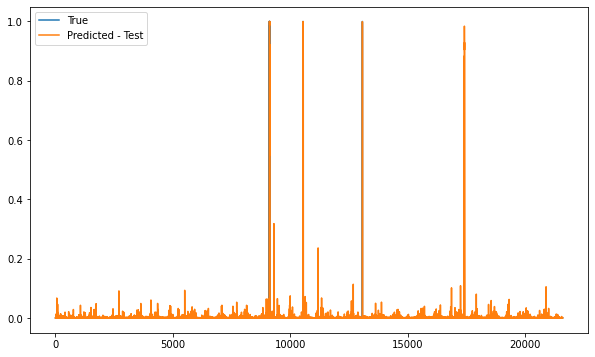

In [393]:
pred_list=[]
BATCH_SIZE2=2160
##测试instance
X_test_instance= X0
#targt series
Y_test_instance= Y0
y_instance_label=y_label[T:len(Y0)-step]

y_instance_pred=np.zeros((len(y_instance_label)))

batch_idx = np.array(range(int(len(y_instance_pred)/10)))*10

X = np.zeros((len(batch_idx), T +step, len(a)))
y_history = np.zeros((len(batch_idx),T +step))
for j in range(len(batch_idx)):
    X[j, :, :] = X_test_instance[range(batch_idx[j], batch_idx[j] + T +step), :]
    y_history[j, :] = Y_test_instance[range(batch_idx[j],  batch_idx[j]+ T +step)]


    #_, input_encoded = encoder(Variable(torch.from_numpy(X).type(torch.FloatTensor).cuda()))
    #input_final=decoder(input_encoded,Variable(torch.from_numpy(y_history).type(torch.FloatTensor).cuda()))
    #print(input_final)
    #print(mil(input_final).cpu().data.numpy()[:, 0])

y_instance_pred= model.evaluate(Variable(torch.from_numpy(X).type(torch.FloatTensor).cuda()),
                        Variable(torch.from_numpy(y_history).type(torch.FloatTensor).cuda())).cpu().data.numpy().reshape(len(y_instance_label))
    #print('here1')
    #y_pred[i:(i + BATCH_SIZE)] = mil(Variable(torch.from_numpy(input_final).type(torch.FloatTensor).cuda()))
    #y_pred.append(mil(input_final))

plt.figure(figsize=(10,6))
plt.plot(range(1, 1 + len(y_instance_label)), y_instance_label, label = "True")
plt.plot(range(1 , len(y_instance_pred) +1), y_instance_pred, label = 'Predicted - Test')
plt.legend(loc = 'upper left')
plt.show()
pred_list.append(y_instance_pred)

In [394]:
BATCH_SIZE2=Turns
import random
def pred(data):
    data1=data[:,:,0:-1]
    data2=data[:,:,-1]
    y_pred=model.evaluate(Variable(torch.from_numpy(data1).type(torch.FloatTensor).cuda()),
                        Variable(torch.from_numpy(data2).type(torch.FloatTensor).cuda())).cpu().data.numpy()
    pred=y_pred[:,0,0]
    return pred
def reconstruct(data,i,number):
    datacopy=data.copy()
    for j in range(number):
        datacopy[:,9-j,i]= datacopy[:,9-number,i]
    return datacopy
def random_justify(RTS,number):    
    value0=pred(RTS)
    I=random.sample(range(0,1+len(a)),3)
    RTS1=reconstruct(RTS,I,number)
    value1=pred(RTS1)
    errors=value0-value1
    IM=(errors)/value0
    result=[errors.mean(),IM.mean()]
    return result
print(random_justify(RTS,5))

/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:108: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:133: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


[0.36664566, -0.08337427]


In [395]:
BATCH_SIZE2=1
import random
def pred(data):
    data1=data[:,:,0:-1]
    data2=data[:,:,-1]
    y_pred=model.evaluate(Variable(torch.from_numpy(data1).type(torch.FloatTensor).cuda()),
                        Variable(torch.from_numpy(data2).type(torch.FloatTensor).cuda())).cpu().data.numpy()
    pred=y_pred[:,0,0]
    return pred
def reconstruct(data,i,number):
    datacopy=data.copy()
    for j in range(number):
        datacopy[:,9-j,i]= datacopy[:,9-number,i]
    return datacopy
import time
def new_algo(RTS,num):
    RTS0=RTS.copy()
    RTS1=RTS.copy()
    pk=pred(RTS0)
    print(f'original posiibility is {pk}')
    Q=[]
    PC=[]
    for t in range(1,T-1):
        start_time=time.time()
        I=[]
        for j in range(num):
            Loss=np.zeros((RTS.shape[2]))
            for i in range(RTS.shape[2]):
                y_pred=pred(reconstruct(RTS0,i,t))
                pc=y_pred
                Loss[i]=pc
                imin=np.argmin(Loss)
            if pred(reconstruct(RTS0,imin,t))>pk:
                break
            elif imin in I:
                break
            else:
                I.append(imin)
            RTS0=reconstruct(RTS0,imin,t)
            pc=pred(RTS0)
#             if pk-pc<0.01:
#                 break
            print(f'possiility after reset of {I}is {pc}')
        finish_time=time.time()
        print(f'time costed is{finish_time-start_time}')
        if (pk-pc)/pc>=0.4:
            return I,t,(pk-pc)/pk,pk-pc
        else:
            Q.append(I)
            PC.append(pc)
            print(f'at stamp of {t},possibility after is {pc}')
    tmin=np.argmin(PC)
    J=Q[tmin]
    y_pred=pred(reconstruct(RTS1,J,tmin))
    im=(pk-PC[tmin])/pk
    error=pk-PC[tmin]
    return Q[tmin],tmin,im,error

In [396]:
I_total=[]
t_total=[]
im_total=[]
error_total=[]
for i in range(len(RTS)):
    print(i)
    if pred(RTS[i][np.newaxis,:,:])>0:
        I,t,im,error=new_algo(RTS[i][np.newaxis,:,:],3)
        I_total.append(I)
        t_total.append(t)
        im_total.append(im)
        error_total.append(error)

0


/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:108: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/liuchen/.conda/envs/cl/lib/python3.6/site-packages/ipykernel_launcher.py:133: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


original posiibility is [0.00108014]
possiility after reset of [2]is [0.00107875]
possiility after reset of [2, 1]is [0.00107778]
time costed is2.3950464725494385
at stamp of 1,possibility after is [0.00277944]
possiility after reset of [0]is [0.00107565]
time costed is1.5520293712615967
at stamp of 2,possibility after is [0.00111173]
possiility after reset of [0]is [0.00107565]
time costed is1.5567116737365723
at stamp of 3,possibility after is [0.01203465]
possiility after reset of [3]is [0.00079076]
possiility after reset of [3, 1]is [0.00077127]
time costed is2.3905422687530518
at stamp of 4,possibility after is [0.00144986]
possiility after reset of [0]is [0.00079074]
time costed is1.5583581924438477
at stamp of 5,possibility after is [0.00181269]
possiility after reset of [0]is [0.00075074]
time costed is1.5524206161499023
at stamp of 6,possibility after is [0.00166313]
possiility after reset of [1]is [0.00077726]
time costed is1.5527467727661133
at stamp of 7,possibility after i

time costed is1.5554726123809814
at stamp of 7,possibility after is [0.99993527]
possiility after reset of [0]is [0.9980147]
time costed is1.5571389198303223
at stamp of 8,possibility after is [0.9999684]
10
original posiibility is [0.99944216]
possiility after reset of [4]is [0.99910104]
possiility after reset of [4, 1]is [0.99910104]
time costed is2.391674757003784
at stamp of 1,possibility after is [0.99910104]
possiility after reset of [4]is [0.99729556]
possiility after reset of [4, 0]is [0.99729556]
time costed is2.390486478805542
at stamp of 2,possibility after is [0.99729556]
possiility after reset of [1]is [0.99729556]
time costed is1.5544250011444092
at stamp of 3,possibility after is [0.99890053]
possiility after reset of [3]is [0.99725133]
possiility after reset of [3, 2]is [0.99725133]
time costed is2.39290189743042
at stamp of 4,possibility after is [0.9988846]
possiility after reset of [1]is [0.99725133]
time costed is1.5553350448608398
at stamp of 5,possibility after is

time costed is2.3732287883758545
at stamp of 3,possibility after is [0.9691543]
possiility after reset of [4]is [0.9577364]
possiility after reset of [4, 2]is [0.957733]
time costed is2.377645254135132
at stamp of 4,possibility after is [0.957733]
possiility after reset of [1]is [0.95772886]
time costed is1.5627453327178955
at stamp of 5,possibility after is [0.9992073]
possiility after reset of [0]is [0.95772743]
time costed is1.5362398624420166
at stamp of 6,possibility after is [0.99974483]
possiility after reset of [3]is [0.9559324]
possiility after reset of [3, 0]is [0.9559321]
time costed is2.3923685550689697
at stamp of 7,possibility after is [0.99973816]
possiility after reset of [3]is [0.95589036]
possiility after reset of [3, 0]is [0.9558896]
possiility after reset of [3, 0, 2]is [0.9558893]
time costed is2.5673909187316895
at stamp of 8,possibility after is [0.9558893]
17
original posiibility is [0.9990074]
possiility after reset of [4]is [0.99742234]
possiility after reset 

In [397]:
print(np.array(error_total).mean())
print(np.array(im_total).mean())
# print(error_total)
# print(im_total)

0.45102653
0.50199586
